In [1]:
# Import necessary packages
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, grid)
from gerrychain.metrics import mean_median, partisan_bias, polsby_popper, efficiency_gap
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import inspect
import pickle
import geopandas as gp
from shapely.geometry import LineString, Polygon
from shapely.ops import unary_union
import itertools
import math

In [2]:
# Import tools file
from merges import *
from plotting import *

In [3]:
precincts = gp.read_file("UtahData/new_shp.shp")

In [4]:
# The precincts file in the cell above is essentially equivalent to 
precincts_old = gp.read_file('UtahData/2018_precincts_w_votes_and_pop.shp')

# with the following changes made
precincts_old.loc[101, 'geometry'] = precincts_old.loc[101, 'geometry'][0]
precincts_old.loc[175, 'geometry'] = precincts_old.loc[175, 'geometry'][0]
# (deleting small islands)
precincts_old.loc[1887, 'US_Distric'] = 1
# (changing the district of a precinct in Summit County to reflect the fact that all of Summit County is in district 0)

In [5]:
# Get the graph data
utah = Graph.from_json("UtahData/graph.json")

In [6]:
# The graph in the cell above is essentially equivalent to 
graph_old = Graph.from_json('UtahData/2018_full_with_clean_buffer_graph.json')

# with the following change made:
graph_old.nodes[1887]['US_Distric'] = 1
# (changing the district of a precinct in Summit County to reflect the fact that all of Summit County is in district 0)

# Pre-processing

In [7]:
# Choose the graph and gdf we are working with
graph, gdf = utah.copy(), precincts.copy()

## District Issues

In [8]:
# Put precinct 1887 (population zero) into district 1.
# (I believe this is an error because several online sources list that all of Summit County is in district 1.)
graph.nodes[1887]['US_Distric'] = 1
gdf.loc[1887, 'US_Distric'] = 1

In [9]:
columns = ['SEN_REP', 'SEN_DEM', 'G_DEM', 'G_REP']
for column in columns:
    s = np.nonzero(gdf[column].isnull().values)
    for i in s[0]:
        gdf.iloc[i, gdf.columns.get_loc(column)] = 0

## Geometry Issues

In [10]:
# Delete small sliver
gdf.loc[40, 'geometry'] = precincts.loc[40,'geometry'][0]

# Delete small sliver
gdf.loc[229, 'geometry'] = precincts.loc[229, 'geometry'][0]

# Delete small sliver (new)
gdf.loc[281, 'geometry'] = precincts.loc[281, 'geometry'][0]

# Delete small island
gdf.loc[543,'geometry'] = precincts.loc[543,'geometry'][0]

# Delete several small slivers
gdf.loc[636,'geometry'] = precincts.loc[636, 'geometry'][0]

In [12]:
# Find the multipolygons
multipolygons = []
for i, poly in enumerate(gdf['geometry']):
    if type(poly) != Polygon:
        multipolygons.append(i)
print(multipolygons)

[17, 19, 90, 107, 109, 112, 118, 128, 130, 131, 137, 139, 140, 141, 142, 146, 150, 152, 156, 161, 211, 235, 238, 239, 242, 248, 249, 262, 315, 317, 318, 319, 321, 322, 323, 330, 331, 341, 343, 363, 395, 444, 515, 525, 532, 556, 557, 569, 599, 602, 604, 607, 610, 613, 615, 624, 629, 630, 634, 638, 646, 661, 670, 688, 719, 722, 749, 844, 957, 981, 1004, 1012, 1013, 1014, 1016, 1021, 1051, 1121, 1131, 1138, 1139, 1145, 1151, 1164, 1165, 1171, 1220, 1224, 1229, 1230, 1242, 1256, 1258, 1280, 1294, 1295, 1307, 1308, 1315, 1319, 1320, 1345, 1353, 1357, 1360, 1361, 1369, 1372, 1375, 1393, 1406, 1414, 1419, 1423, 1430, 1467, 1502, 1510, 1515, 1516, 1518, 1523, 1530, 1531, 1548, 1570, 1571, 1577, 1600, 1604, 1605, 1606, 1607, 1608, 1611, 1612, 1613, 1614, 1615, 1616, 1619, 1623, 1638, 1645, 1646, 1650, 1667, 1688, 1692, 1714, 1715, 1716, 1729, 1731, 1739, 1744, 1749, 1759, 1760, 1763, 1765, 1769, 1770, 1783, 1798, 1808, 1810, 1812, 1816, 1821, 1822, 1824, 1825, 1828, 1830, 1887, 1929, 1995, 1997

In [13]:
# Delete very small islands

# necessary to amend 2164, 2468, 2664
# 1423, 1744, 2532, 2885, 2906, 2957 also included 

tol = 1 # square meter 
for mp in multipolygons:
    multip = gdf.iloc[mp]['geometry']
    if sum(poly.area for poly in multip[1:]) < tol:
        print(mp)
        gdf.loc[mp, 'geometry'] = gdf.loc[mp, 'geometry'][0]

1423
1744
2164
2468
2532
2664
2885
2906
2957


In [14]:
# Set some common parameters for merging
columns_to_keep = ['geometry', ('CountyID', 'first'), ('VistaID', 'sum'), ('POP100', 'sum'), 
                                 ('SEN_DEM', 'sum'), ('SEN_REP', 'sum'), ('G_DEM', 'sum'), ('G_REP', 'sum'),
                                 ('US_Distric', 'first'), ('UT_SEN','first'), ('UT_HOUSE','first')]

column_labels = ['geometry', 'CountyID', 'VistaID', 'POP100', 'SEN_DEM', 'SEN_REP', 'G_DEM',
                                 'G_REP' , 'US_Distric', 'UT_SEN', 'UT_HOUSE']

attributes_to_sum = ['POP100', 'area', 'SHAPE_Area', 'SEN_DEM', 'SEN_REP', 'G_DEM', 'G_REP']

attributes_to_join = ['VistaID', 'PrecinctID', 'SubPrecinc']

In [15]:
precincts.drop('index', axis=1, inplace=True)

In [16]:
# These precincts have to be merged
merge_init = Merge(len(graph))
merge_init.add(set([2957, 2967]))
dissolve_init = merge_init.get_dissolve()

# Perform the merge
gdf_init = perform_dissolve_gdf(gdf, dissolve_init, columns_to_keep, column_labels)
graph_init = perform_dissolve_graph(graph, dissolve_init, attributes_to_sum, attributes_to_join)

C:\Users\Jacob\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [17]:
# Delete two small islands
s = gdf_init.loc[2957, 'geometry']
i = np.argmax([s[i].area for i in range(len(s))])
gdf_init.loc[2957, 'geometry'] = gdf_init.loc[2957, 'geometry'][i]

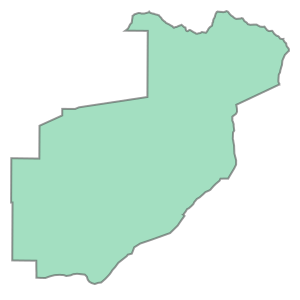

In [18]:
gdf_init.loc[2957, 'geometry']

# Section 1: Merging Multipolygons

All of the precincts geometries are either a shapely Polygon or a list of shapely Polygons, called a Multipolygon. A Polygon may not be simply connected (i. e. it may have holes) but it will be connected. For Multipolygons we have no such guarantee, and in fact we have reason to suspect that they are disconnected (otherwise they could be cast into a Polygon). To make sure that our Markov chain does not generate disconnected districts, we must ensure that each of the underlying precincts are connected. We can do this by finding all of the precincts which are of type Multipolygon, and then merging them with one of their neighbors. In my code, this choice is made by determining which of the neighbors in the same county and congressional district has the largest shared perimeter with a given district, and then merging that polygon. 

In [21]:
# Choose the graph we operate on 
graph, gdf = graph_init, gdf_init

In [45]:
# Find the multipolygons
multipolygons = []
for i, poly in enumerate(gdf['geometry']):
    if type(poly) != Polygon:
        multipolygons.append(i)
        print(len(poly), end=',')
print(multipolygons)

2,4,2,3,2,2,3,2,3,7,5,5,4,2,2,2,2,2,2,3,2,2,4,8,2,3,2,2,2,3,4,3,2,2,2,2,2,2,6,4,2,2,2,3,2,2,3,2,2,2,2,2,3,2,3,3,2,3,2,2,2,4,3,2,2,2,3,2,3,2,2,2,4,2,3,4,3,2,2,2,2,2,2,2,2,2,3,2,2,2,2,2,3,3,2,2,2,2,2,2,2,3,5,3,2,3,2,2,5,2,2,2,5,8,3,2,2,2,2,2,2,2,2,2,2,3,2,2,4,6,7,2,3,2,3,9,9,13,2,6,2,2,3,2,3,2,2,4,6,2,2,2,2,2,8,2,2,5,2,7,3,2,2,3,3,3,3,4,3,2,10,3,2,4,2,2,2,2,2,2,2,3,2,2,3,2,3,2,2,2,2,2,6,3,2,2,3,4,2,2,3,2,2,2,3,2,2,2,2,3,3,2,2,4,5,3,2,2,2,2,2,2,6,2,2,2,3,2,2,2,3,2,6,2,3,[17, 19, 90, 107, 109, 112, 118, 128, 130, 131, 137, 139, 140, 141, 142, 146, 150, 152, 156, 161, 211, 235, 238, 239, 242, 248, 249, 262, 315, 317, 318, 319, 321, 322, 323, 330, 331, 341, 343, 363, 395, 444, 515, 525, 532, 556, 557, 569, 599, 602, 604, 607, 610, 613, 615, 624, 629, 630, 634, 638, 646, 661, 670, 688, 719, 722, 749, 844, 957, 981, 1004, 1012, 1013, 1014, 1016, 1021, 1051, 1121, 1131, 1138, 1139, 1145, 1151, 1164, 1165, 1171, 1220, 1224, 1229, 1230, 1242, 1256, 1258, 1280, 1294, 1295, 1307, 1308, 1315, 1319, 

In [62]:
for i, poly in enumerate(gdf['geometry']):
    if type(poly) != Polygon:
        a = np.array([poly[i].area for i in range(len(poly))])
        v = a[np.argsort(-a)]
        print(v[0]/v[1])

1.534828233797436
784829.6823947116
18.59774162564037
1.603350144203328
566.6330452772153
1.379342479762646
1.2525551620249595
135.89455328576614
7.188565553437501
1.808795608909688
6.178185256118579
48.74077996265383
1.0741440691488715
3.8924630662986974
4931280.124718681
14.896219259344784
1.9244987742207904
1.6209483887304594
69.7241441502346
3.0539909824701064
24702.10226208828
9.760175760447504
801.686654735492
11.437708720482448
8161.056469660072
28.82421699983807
51.09972539679318
27.573605038903885
20.409860533637037
44.712099265710904
307.7805742879325
19.058826694018208
1.7064067814560884
9.22241206340427
64.48122729619024
8.765934621148192
45.78706991730604
555.4757649788631
9.166498450749668
3.201818183493743
3.0644450301800137
43694.91615619306
1.262710511990664
2.9354112493170703
1.0275007997057133
24.240052992814213
2.4361721838658306
100.19948553117366
42.32193792599194
2.465881177054986
54.192544528608096
21.116908749787545
6.600268958310475
1.2868008302358205
1.095290

(206340.0469999997, 696211.4729999999, 4066802.5100000007, 4681513.089999999)

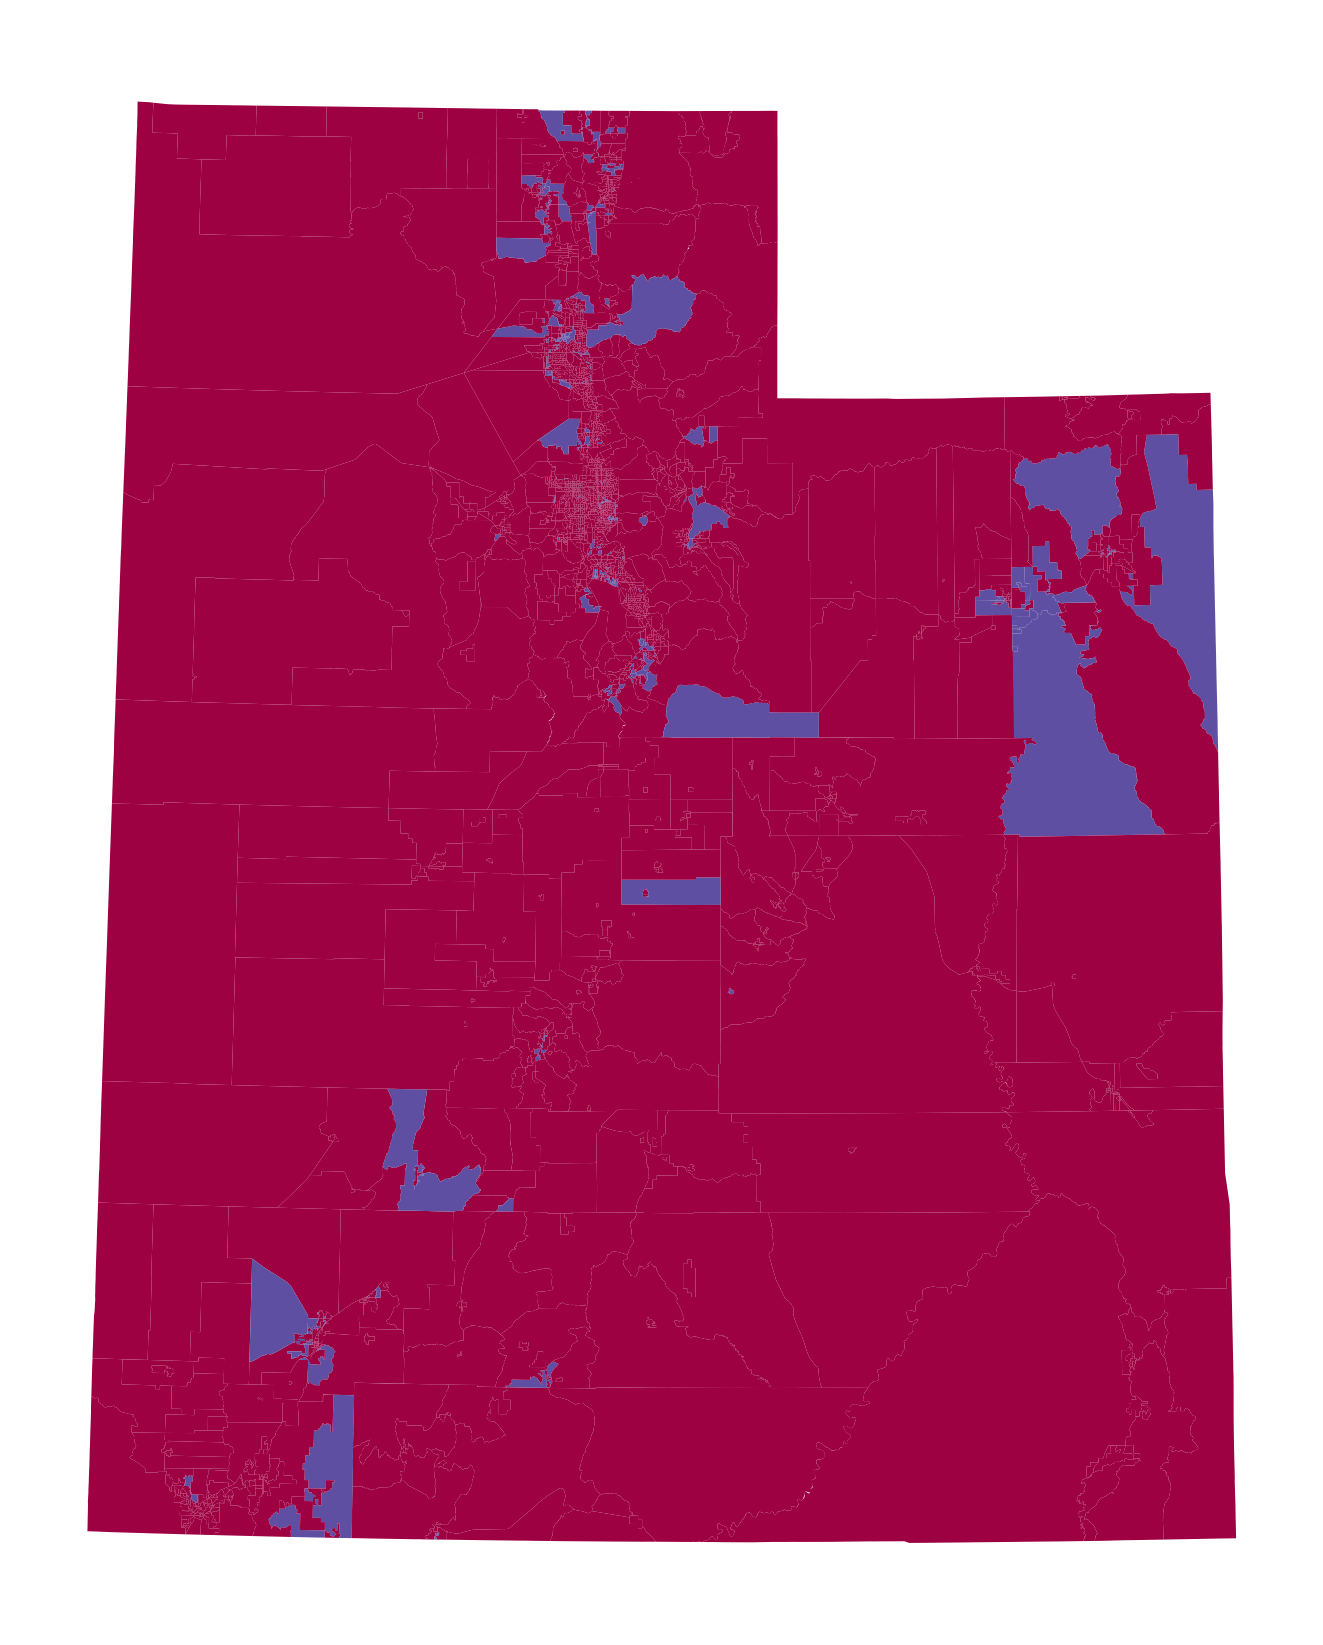

In [23]:
# Mark the multipolygons
f = gdf.copy()
mp = np.array([1 if i in multipolygons else 0 for i in range(len(f))])
f['mp'] = mp

# Plot the multipolygons
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Multipolygon

In [42]:
# time to run: approx 1 min. Gets stuck at 171 for a little, but don't worry
merge_mp = merge_multipolygons(graph, gdf, preserve=['CountyID', 'US_Distric', 'UT_SEN', 'UT_HOUSE'])
dissolve_mp = merge_mp.get_dissolve()

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [40]:
def voting_units(graph, preserve=['CountyID', 'US_Distric', 'UT_SEN', 'UT_HOUSE']):
    
    # Get a list of all of the relevant precinct attributes
    u = [tuple(graph.nodes[i][attr] for attr in preserve) for i in range(len(graph.nodes))]
    
    u_array = np.array(u, dtype=(np.int32, 4))
    
    m = Merge(len(u))
    
    # Combine precincts that match on all of the attributes in 'preserve'
    for val in set(u):
        m.add(set(list(np.nonzero(np.all(u_array == val, axis=1))[0])))
    
    return m

def merge_multipolygons2(graph, gdf, preserve=['CountyID', 'US_Distric', 'UT_SEN', 'UT_HOUSE']):
    """
    This function attempts to create a merge which dissolves all multipolygons into polygons.

    Parameters:
        graph (nx.Graph): an adjacency graph for the precincts
        gdf (GeoDataFrame): a gdf of the precinct geometries
        preserve (list): a list of parameters in the graph that must be
        preserved (i.e. precincts selected for merging must be the same in these parameters)

    Returns:
        merge (Merge): a Merge object containing the proposed merges
    """

    # Find all the multipolygons
    multipolygons = []
    for i, poly in enumerate(gdf['geometry']):
        if type(poly) != Polygon:
            multipolygons.append(i)

    merges = Merge(len(graph))
    
    u = voting_units(graph, preserve).get_dissolve()

    # Iterate over the multipolygons
    for i, mp in enumerate(multipolygons):

        print(i, end=', ')

        neighbors = list(np.nonzero(u == u[mp])[0])

        # Set parameters
        possibilities = []
        comb_number = 1

        # hopefully we only have to go through this loop once
        while len(possibilities) == 0:

            # Iterate through all combinations of neighboring precincts
            # At the beginning, just try combinations of length 1
            for comb in itertools.combinations(neighbors, comb_number):

                # Merge adjacent polygon(s)
                s = unary_union(list(gdf.iloc[mp]['geometry']) + [gdf.iloc[n]['geometry'] for n in comb])

                # If the merge worked, store it as a possibility
                if type(s) == Polygon:
                    possibilities.append(list(comb))

                # If merging with one neighbor fails to work, we will have to try merging with two neighbors
                comb_number += 1

        # Maximizing the shared perimeter of the precincts being merged is a decent way to pick good merges
        # Find argmax graph[mp][p]['shared_perim'] for p in possibilities
        best = possibilities[np.argmax([sum(graph[mp].get(n, {'shared_perim':0})['shared_perim'] for n in comb) for comb in possibilities])]
        merges.add(set([mp] + best))

    return merges

In [41]:
# time to run: approx 1 min. Gets stuck at 171 for a little, but don't worry
merge_mp2 = merge_multipolygons2(graph, gdf, preserve=['CountyID', 'US_Distric', 'UT_SEN', 'UT_HOUSE'])
dissolve_mp2 = merge_mp2.get_dissolve()

0, 1, 2, 3, 4, 5, 

KeyboardInterrupt: 

(206340.0469999997, 696211.4729999999, 4066802.5100000007, 4681513.089999999)

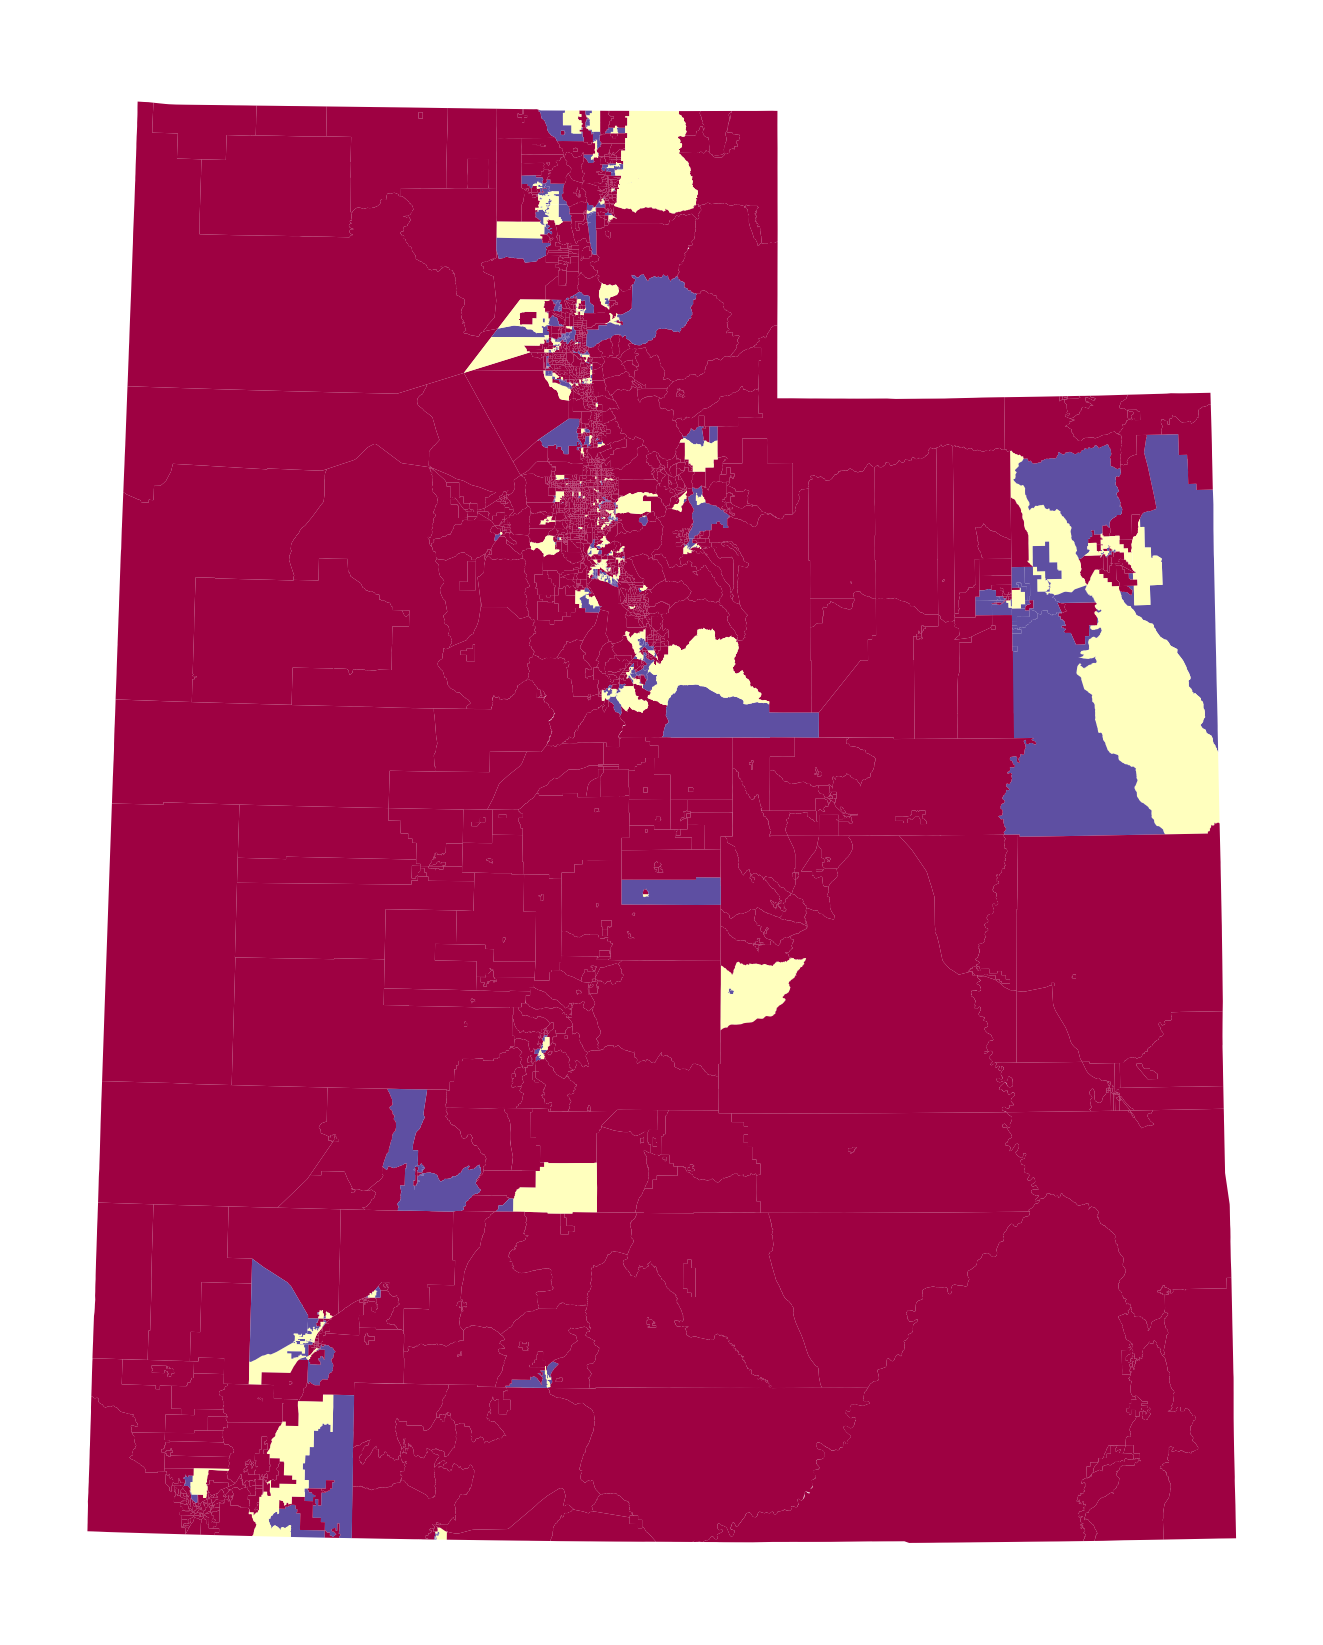

In [44]:
# Get the multipolygons along with the nodes they will be merged with
f = gdf.copy()
s = set([subpart for part in merge_mp.merges for subpart in part])
mps_and_neighbors = np.array([1 if (n in s) else 0 for n in range(len(f)) ])

f['mp'] = 0.5*(mp + mps_and_neighbors)

# Plot the zero-population nodes
size, dpi = (14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Multipolygon, Yellow: Neighboring precinct selected to be merged 

In [ ]:
merge_mp2 = merge_init * merge_mp
dissolve_mp2 = merge_mp2.get_dissolve()

In [ ]:
# Perform the merge
gdf_mp = perform_dissolve_gdf(gdf_init, dissolve_mp, columns_to_keep, column_labels)
graph_mp = perform_dissolve_graph(graph_init, dissolve_mp, attributes_to_sum, attributes_to_join)

In [ ]:
# We decreased by
len(graph_mp) - len(graph_init)

In [ ]:
# Plot the results

f = gdf_mp.copy()
f['mp'] = np.array([1 if i in dissolve_mp[multipolygons] else 0 for i in range(len(f))])

# Plot the multipolygons
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Merged Multipolygon

# Section 2: One Neighbor Precincts and Separating Precincts

One essential motivation for merging precincts is to streamline the process of using Monte Carlo Markov Chain models via the flip proposal. The flip proposal is the transition between states in our Markov chain. It selects a precinct on one of the cut edges of the graph, and then changes its district assignment to the adjacent district. This transition forms a reversible Markov Chain. By simulating thousands of these flips, we hope to explore the sample space of possible districting plans. However, the flip proposal has some limitations. In particular, if precint A is contained inside precinct B (and thus has no other neighboring precincts) and precinct B is selected to be flipped, when the new districting assignment is generated, B's old district will be left discontiguous and thus invalid, because A will be a disconnected precinct in the old district. The algorithm will reject the new proposed plan due to its invalidity. Therefore, the precinct B (and precinct A) can never be flipped into a different district, and the Markov chain will not explore the whole sample space, and may be confined to a particular region of the sample space. Of course, the solution is that A and B can be flipped if they are flipped together. The simplest way to proceed is to use the normal flipping algorithm, but after having merged precincts A and B.

In [ ]:
# Choose the graph we operate on 
graph, gdf = graph_mp, gdf_mp

In [ ]:
# Find all the separating precincts, approx 5 min
ids2, neighbor_ids2, separators, merge_sp = get_separators(graph)

In [ ]:
# Confirm that donut precincts are in the same senate and house districts as the precincts they contain
for part in merge_sp.merges:
    part = list(part)
    cong, sen, house = graph.nodes[part[0]]['US_Distric'], graph.nodes[part[0]]['UT_SEN'], graph.nodes[part[0]]['UT_HOUSE']
    
    for precinct in part:
        cong1, sen1, house1 = graph.nodes[precinct]['US_Distric'], graph.nodes[part[0]]['UT_SEN'], graph.nodes[precinct]['UT_HOUSE']
    
        if (cong1 != cong) or (sen1 != sen) or (house1 != house):
            print(precinct)
        

In [ ]:
# Mark the one-neighbor nodes
f = gdf.copy()
f["one neighbor"] = np.array([1 if (i in ids2 or i in neighbor_ids2) else 0 for i in range(len(f))])

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='one neighbor', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Normal Precinct, Blue: Separating precinct, or precinct contained in it

# plt.savefig("isolated_precincts2.png", dpi=dpi, bbox_inches="tight")

# Look at Sanpete County!

In [ ]:
dissolve_sp = merge_sp.get_dissolve()

# Merge so that the new merged precincts are flippable
gdf_mp_sp = perform_dissolve_gdf(gdf_mp, dissolve_sp, columns_to_keep, column_labels)
graph_mp_sp = perform_dissolve_graph(graph_mp, dissolve_sp, attributes_to_sum, attributes_to_join)

In [ ]:
merge_mp_sp = merge_mp2 * merge_sp
dissolve_mp_sp = merge_mp_sp.get_dissolve()

In [ ]:
# Mark the merged precincts
f = gdf_mp_sp.copy()
f["one neighbor"] = np.array([1 if (n in dissolve_sp[ids2] or n in dissolve_sp[neighbor_ids2]) else 0 for n in range(len(f))])

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='one neighbor', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Normal Precinct, Blue: Separating precinct, or precinct contained in it (Merged)
# plt.savefig("isolated_precincts_merged1.png", dpi=dpi, bbox_inches="tight")

In [ ]:
# We decreased by
len(graph_mp) - len(graph_mp_sp)

In [ ]:
# No multipolygons
all(type(poly) == Polygon for poly in gdf_mp_sp['geometry'])

In [ ]:
# No separating precincts (approx 5 min to run)
separate = []
for node in graph_mp_sp:
    copy = graph_mp_sp.copy()
    copy.remove_node(node)
    separate.append(nx.is_connected(copy))
all(separate)

In [ ]:
# Check that the total population stayed the same
sum(graph_mp_sp.nodes[n]['POP100'] for n in graph_mp_sp.nodes) == sum(utah.nodes[n]['POP100'] for n in utah.nodes)

In [ ]:
len(graph_mp_sp)

Now we can package these files up:

In [ ]:
# this is how the files were originally created

#gdf_mp_sp.to_file("gdf_mp_sp.shp")
#pickle.dump(graph_mp_sp, open("graph_mp_sp.pkl", 'wb'))

In [ ]:
# Compare the result to the currently stored files
graph2 = pickle.load(open('UtahData/graph_mp_sp.pkl', 'rb'))
gdf2 = gdf.from_file('UtahData/gdf_mp_sp.shp')

In [ ]:
graph2.edges() == graph_mp_sp.edges()

In [ ]:
all(gdf2['geometry'] == gdf_mp_sp['geometry'])

# Look at the results:

In [ ]:
plot_graph(gdf_mp_sp, graph_mp_sp)